In [12]:
import pandas as pd
import numpy as np
df = pd.read_csv("dft-road-casualty-statistics-collision-2023.csv")
print("shape before cleaning:", df.shape)
print(df.head())
df = df.drop(columns=["local_authority_district"])

df = df.replace(-1, np.nan)
print(df.isnull().sum())

df["datetime"] = pd.to_datetime(
    df["date"].astype(str) + " " + df["time"].astype(str), 
    format="%d/%m/%Y %H:%M")

df = df.drop(columns=["date", "time"])


df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)


df = df.dropna()
print(df.isnull().sum())
print("shape after cleaning:")
print(df.shape)
print(df.info())
print(df.describe())
sev = df["collision_severity"].value_counts()
print("collision severity counts:")
print(sev)


shape before cleaning: (104258, 44)
  collision_index  collision_year collision_ref_no  location_easting_osgr  \
0   2023170L30453            2023        170L30453               456584.0   
1   2023111293075            2023        111293075               434218.0   
2   2023111312748            2023        111312748               430616.0   
3   2023070702777            2023        070702777               360889.0   
4   2023070866538            2023        070866538               360571.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                522423.0  -1.125794  54.593835            17   
1                514041.0  -1.472891  54.520515            11   
2                514267.0  -1.528511  54.522776            11   
3                389063.0  -2.589645  53.396939             7   
4                389398.0  -2.594469  53.399926             7   

   collision_severity  number_of_vehicles  ...  carriageway_hazards_historic  \
0                   3         


SIMPLE LINEAR REGRESSION (vehicles -> casualties)
MSE: 0.4655193290996865
R2 : 0.04621992593072988
Coef: 0.22757428933288149 Intercept: 0.8750680114537732


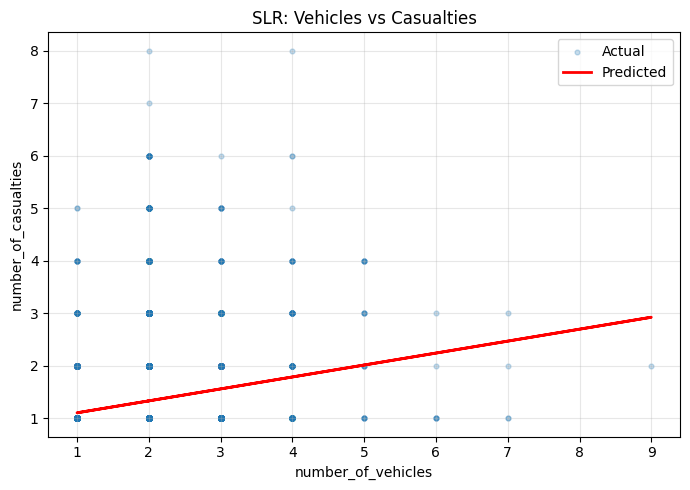


MULTIPLE LINEAR REGRESSION (vehicles + speed + light + weather -> casualties)
MSE: 0.46007391990391444
R2 : 0.0586813720000654


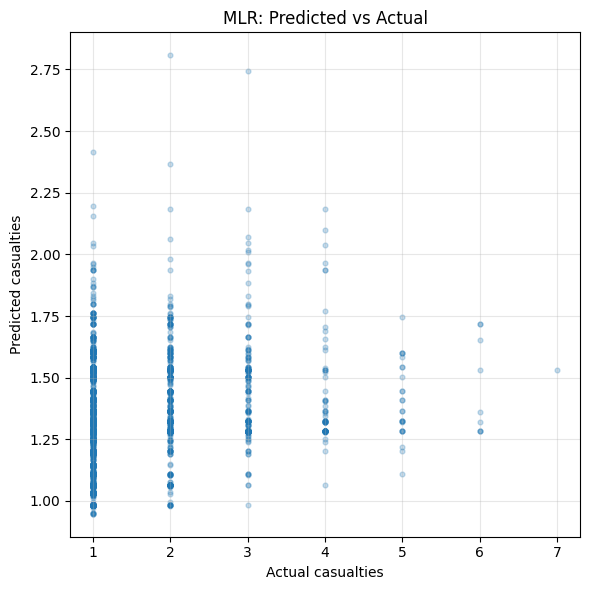


POLYNOMIAL REGRESSION (speed_limit^2 -> casualties)
MSE: 0.480702480317749
R2 : 0.01647500613951003


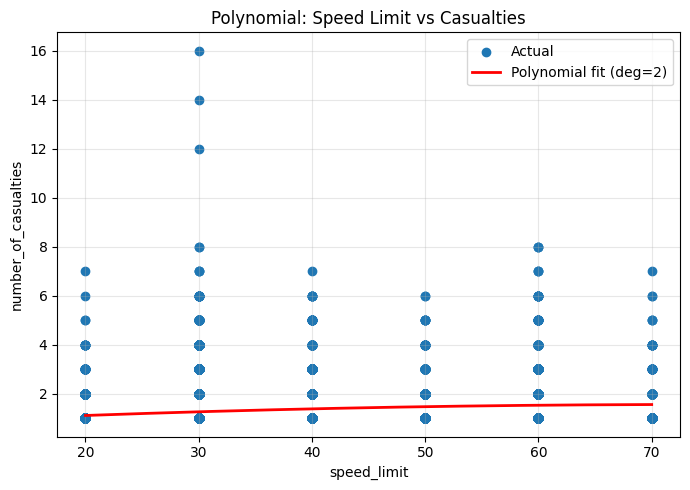

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
#Target and feature for all regressions
y = df["number_of_casualties"]


# SIMPLE LINEAR REGRESSION

X_slr = df[["number_of_vehicles"]]

X_train, X_test, y_train, y_test = train_test_split(X_slr, y, test_size=0.3, random_state=42)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_pred = slr.predict(X_test)

print("\nSIMPLE LINEAR REGRESSION (vehicles -> casualties)")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))
print("Coef:", slr.coef_[0], "Intercept:", slr.intercept_)

plt.figure(figsize=(7,5))
plt.scatter(X_test["number_of_vehicles"], y_test, s=12, alpha=0.25, label="Actual")

plt.plot(X_test["number_of_vehicles"], y_pred, color="red", lw=2, label="Predicted")
plt.title("SLR: Vehicles vs Casualties")
plt.xlabel("number_of_vehicles")
plt.ylabel("number_of_casualties")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# B) MULTIPLE LINEAR REGRESSION

features = ["number_of_vehicles", "speed_limit", "light_conditions", "weather_conditions"]
X_mlr_raw = df[features]


X_mlr = pd.get_dummies(X_mlr_raw, drop_first=True)

Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_mlr, y, test_size=0.2, random_state=42)

mlr = LinearRegression()
mlr.fit(Xm_train, ym_train)
ym_pred = mlr.predict(Xm_test)

print("\nMULTIPLE LINEAR REGRESSION (vehicles + speed + light + weather -> casualties)")
print("MSE:", mean_squared_error(ym_test, ym_pred))
print("R2 :", r2_score(ym_test, ym_pred))

plt.figure(figsize=(6,6))
plt.scatter(ym_test, ym_pred, s=12, alpha=0.25)

plt.title("MLR: Predicted vs Actual")
plt.xlabel("Actual casualties")
plt.ylabel("Predicted casualties")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# C) POLYNOMIAL REGRESSION (deg=2)

X_poly = df[["speed_limit"]]
y_poly = df["number_of_casualties"]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly2 = poly.fit_transform(X_poly)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_poly2, y_poly, test_size=0.2, random_state=42)

pr = LinearRegression()
pr.fit(Xp_train, yp_train)
yp_pred = pr.predict(Xp_test)

print("\nPOLYNOMIAL REGRESSION (speed_limit^2 -> casualties)")
print("MSE:", mean_squared_error(yp_test, yp_pred))
print("R2 :", r2_score(yp_test, yp_pred))

plt.figure(figsize=(7,5))
plt.scatter(X_poly["speed_limit"], y_poly, label="Actual")

x_min, x_max = X_poly["speed_limit"].min(), X_poly["speed_limit"].max()
x_line = pd.DataFrame(np.linspace(x_min, x_max, 200), columns=["speed_limit"])
x_line2 = poly.transform(x_line)
y_line = pr.predict(x_line2)

plt.plot(x_line["speed_limit"], y_line, color="red", lw=2, label="Polynomial fit (deg=2)")
plt.title("Polynomial: Speed Limit vs Casualties")
plt.xlabel("speed_limit")
plt.ylabel("number_of_casualties")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


    number_of_vehicles  speed_limit  hour  dayofweek
2                    2           30    23          6
5                    2           20    23          2
7                    3           30     9          0
10                   2           20     9          0
12                   2           30     7          3
collision_severity
3    18196
2     5945
1      242
Name: count, dtype: int64

KNN Accuracy: 0.7153793574846207


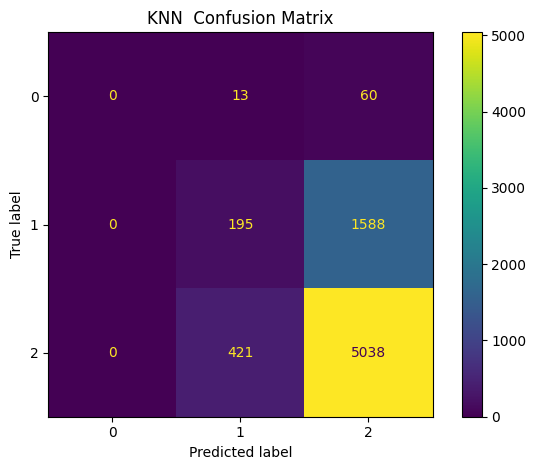

Naive Bayes Accuracy: 0.742447026657553


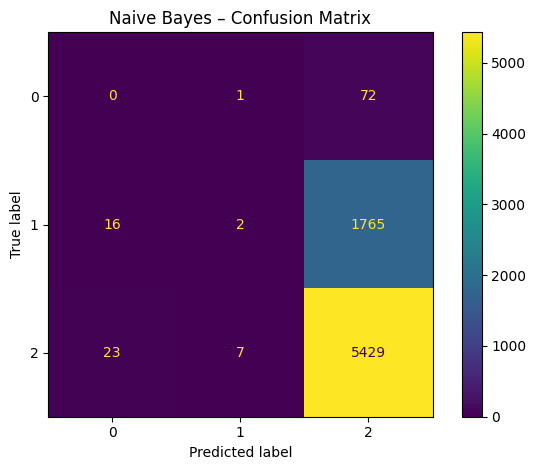

Decision Tree Accuracy: 0.7412166780587833


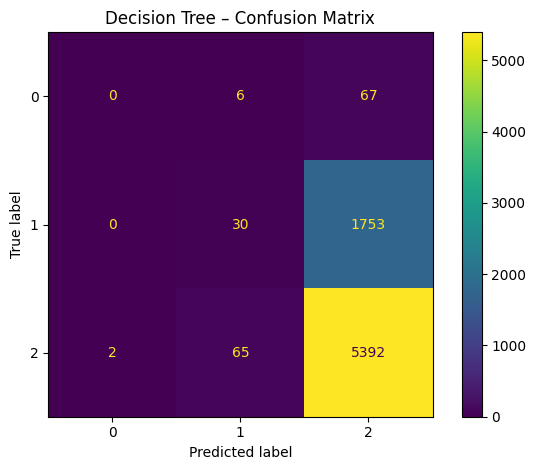

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay




#  Select features and target (simple & interpretable)

X = df[[
    "number_of_vehicles",
    "speed_limit",
    "hour",
    "dayofweek"
]]

y = df["collision_severity"]

print(X.head())
print(y.value_counts())


#  Scaling

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)


# KNN Classifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("\nKNN Accuracy:", accuracy_score(y_test, y_pred_knn))

cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("KNN  Confusion Matrix")
plt.tight_layout()
plt.show()


# Naive Bayes Classifier

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

cm = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Naive Bayes – Confusion Matrix")
plt.tight_layout()
plt.show()


#Decision Tree Classifier

dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Decision Tree – Confusion Matrix")
plt.tight_layout()
plt.show()



KNN Accuracy: 0.7153793574846207


<Figure size 700x500 with 0 Axes>

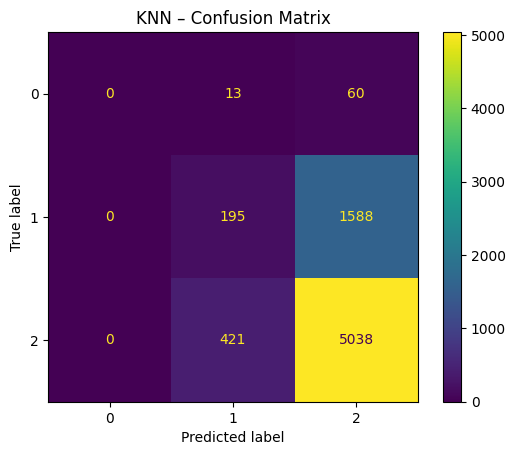

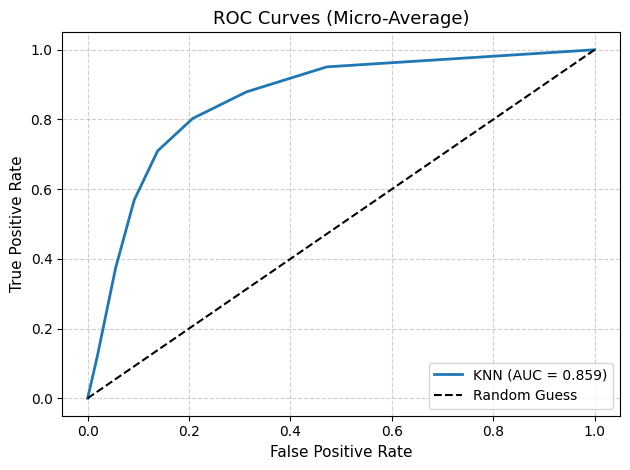

Naive Bayes Accuracy: 0.742447026657553


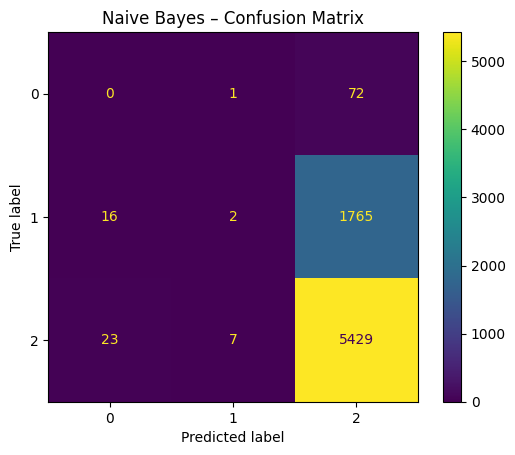

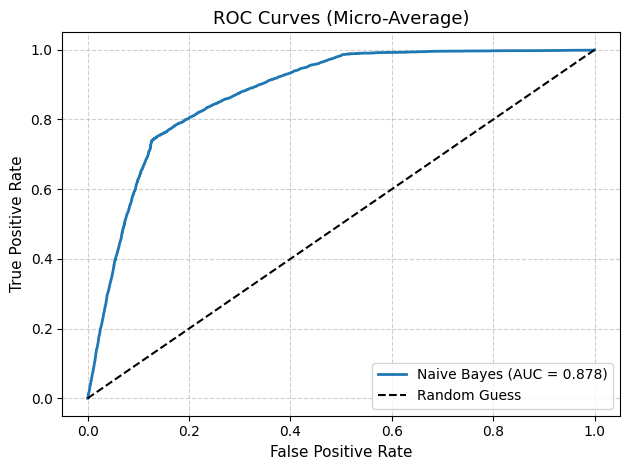

Decision Tree Accuracy: 0.7412166780587833


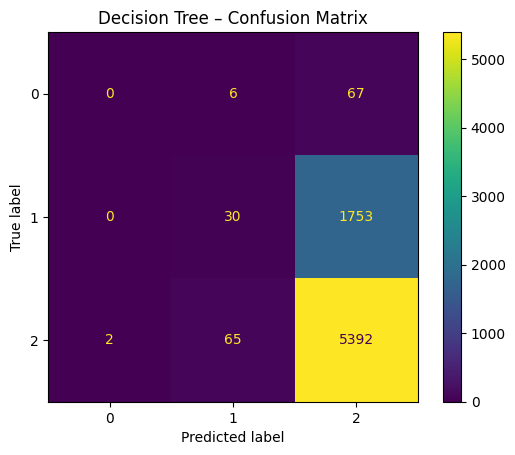

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


X = df[["number_of_vehicles", "speed_limit", "hour", "dayofweek"]]
y = df["collision_severity"]

# Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Binzrizing for roc
classes = np.sort(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)


plt.figure(figsize=(7,5))

# KNN

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)

print("\nKNN Accuracy:", accuracy_score(y_test, y_pred_knn))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn)).plot(values_format="d")
plt.title("KNN – Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob_knn.ravel())
plt.plot(
    fpr, tpr,
    linewidth=2,
    label=f"KNN (AUC = {auc(fpr, tpr):.3f})"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=1.5, label="Random Guess")

plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.title("ROC Curves (Micro-Average)", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#  Naive Bayes

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_nb)).plot(values_format="d")
plt.title("Naive Bayes – Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob_nb.ravel())
plt.plot(
    fpr, tpr,
    linewidth=2,
    label=f"Naive Bayes (AUC = {auc(fpr, tpr):.3f})"
)
plt.plot([0, 1], [0, 1], "k--", linewidth=1.5, label="Random Guess")

plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.title("ROC Curves (Micro-Average)", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



# Decision Tree

dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot(values_format="d")
plt.title("Decision Tree – Confusion Matrix")
plt.show()





Silhouette Score (K=3): 0.1698


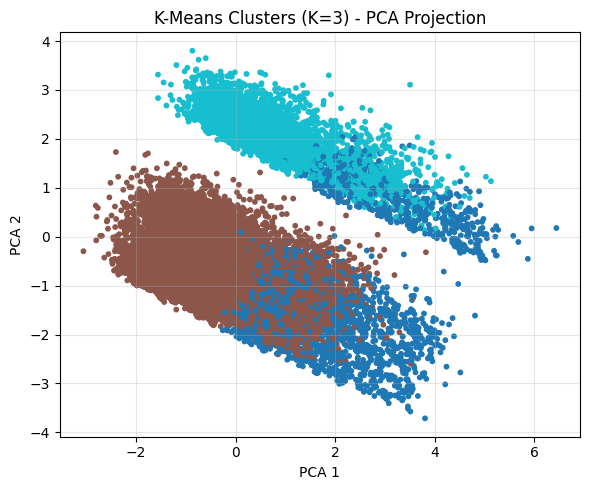


K-Means Cluster Profile (Mean Values):
                speed_limit  number_of_vehicles  number_of_casualties
kmeans_cluster                                                       
0                    40.409               1.912                 1.252
1                    33.172               1.850                 1.276
2                    33.718               1.867                 1.403

Hierarchical Cluster Counts:
hier_cluster
0    17225
2     4228
1     2930
Name: count, dtype: int64


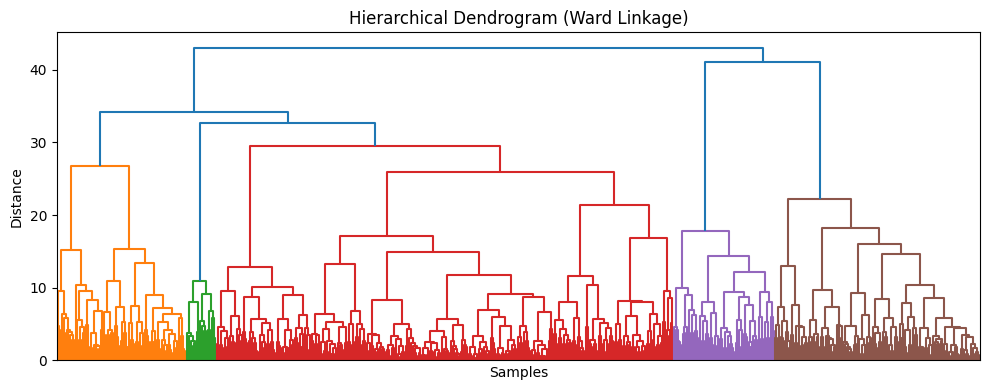

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


# PART A: K-MEANS CLUSTERING (K = 3)

cluster_cols = [
    "speed_limit",
    "number_of_vehicles",
    "number_of_casualties",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "light_conditions",
    "weather_conditions",
    "road_surface_conditions",
    "urban_or_rural_area",
    "road_type",
    "junction_detail",
    "junction_control"
]



X_raw = df[cluster_cols]
X = pd.get_dummies(X_raw, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, df["kmeans_cluster"])
print("Silhouette Score (K=3):", round(sil_score, 4))

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["kmeans_cluster"], cmap="tab10", s=10)
plt.title("K-Means Clusters (K=3) - PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster profiling (numeric interpretation)
profile_cols = ["speed_limit", "number_of_vehicles", "number_of_casualties"]
profile_cols = [c for c in profile_cols if c in df.columns]

print("\nK-Means Cluster Profile (Mean Values):")
print(df.groupby("kmeans_cluster")[profile_cols].mean().round(3))


# PART B: HIERARCHICAL CLUSTERING (AGGLOMERATIVE)


hier = AgglomerativeClustering(n_clusters=3, linkage="ward")
df["hier_cluster"] = hier.fit_predict(X_scaled)

print("\nHierarchical Cluster Counts:")
print(df["hier_cluster"].value_counts())

# Dendrogram (sample for readability)
X_sample = X_scaled[:800]
Z = linkage(X_sample, method="ward")

plt.figure(figsize=(10,4))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Dendrogram (Ward Linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

